<a href="https://colab.research.google.com/github/arunmishrarut/Credit-card-fraud/blob/main/original__final_full_stop_to_model_buidling_and_comparison_part_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Below is the final
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score
import xgboost as xgb
from collections import Counter

# Step 0: Add 'index' column as the first column
data = pd.read_csv('data1.csv')
data.insert(0, 'index', range(len(data)))  # Add index column at the start

# Step 1: Split into train (80%), test (20%) with stratification
rs1 = 43


train, test = train_test_split(
    data, test_size=0.2, stratify=data['Class'], random_state=rs1)



# Step 2: Split train into 6 equal, non-overlapping stratified subsets
n_subsets = 6
skf = StratifiedKFold(n_splits=n_subsets, shuffle=True, random_state=42)
subsets = []
for i, (_, idx) in enumerate(skf.split(train, train['Class'])):
    subset = train.iloc[idx].copy()
    subset['subset'] = f'sub{i+1}'
    subsets.append(subset)

# Prepare to collect tough frauds and legits from all validation subsets
# Remove easy frauds
T = 0.55 #top limit for easy fraud probability (that is if T=0.6 then all frauds(only True frauds & detected,nothing will happend to legits-detected)) from 0.6 to 1.0 prob will be comnsidered easy-to-detect-fraud and will be dropped)
# Remove easy legits
B = 0.45 # lower limit for fraud probability for easy legit. (that is if B=0.4 then all legits (only True legits & detected, nothing will happed to frauds-detected) having prob below 0.4 will be considered easy-to-detect legits)
# Now, apply oversampling with initial lambda values, using per-instance recall/precision
lamda_1 = 2 #(greater than 10 will give greater than 10 and lower than 100 integer)
lamda_2 = 1
fnlt= 0.55 # fntl=>0.5 (if fnlt is 0.7 means it will consider all the instances with fraud-prob below 0.7 as tough-to-identify- frauds)
fput= 0.45 # fput=< 0.5 (if fput is 0.35 means it will consider all the instances with fraud-prob above 0.35 as tough-to-identify legits )
target_fraud_ratio = 0.5


# Storage
all_fn_rows, all_fn_probs, all_fn_recalls = [], [], []
all_fp_rows, all_fp_probs, all_fp_precisions = [], [], []
all_val_sub = []





for eval_idx in range(n_subsets):  # Outer: Evaluation block
    train_val_indices = [i for i in range(n_subsets) if i != eval_idx]
    for val_idx in train_val_indices:  # Inner: Leave-one-out from training blocks
        train_indices = [i for i in train_val_indices if i != val_idx]
        train_subs = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
        val_sub = subsets[eval_idx].copy()  # Evaluation always on this fixed block




        X_train_sub = train_subs.drop(['Class', 'index', 'subset'], axis=1)
        y_train_sub = train_subs['Class']
        X_val = val_sub.drop(['Class', 'index', 'subset'], axis=1)
        y_val = val_sub['Class']

        model = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
        model.fit(X_train_sub, y_train_sub)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Calculate recall and precision for this fold (on remaining val_sub)
        fold_recall = recall_score(y_val, y_pred, zero_division=0)
        fold_precision = precision_score(y_val, y_pred, zero_division=0)

        # Remove easy frauds
        y_pred = pd.Series(y_pred, index=val_sub.index)
        y_proba = pd.Series(y_proba, index=val_sub.index)
        easy_frauds_idx = val_sub[(y_proba > T) & (y_val == 1)].index
        val_sub = val_sub.drop(easy_frauds_idx)
        y_val = y_val.drop(easy_frauds_idx)
        y_pred = y_pred.drop(easy_frauds_idx)
        y_proba = y_proba.drop(easy_frauds_idx)

        # Remove easy legits
        easy_legits_idx = val_sub[(y_proba < B) & (y_val == 0)].index
        val_sub = val_sub.drop(easy_legits_idx)
        y_val = y_val.drop(easy_legits_idx)
        y_pred = y_pred.drop(easy_legits_idx)
        y_proba = y_proba.drop(easy_legits_idx)

        # Collect remaining (tough) false negatives and false positives
        false_negatives_idx = val_sub[(y_val == 1) & (y_proba < fnlt)].index
        fn_rows = val_sub.loc[false_negatives_idx].copy()
        fn_probs = y_proba.loc[false_negatives_idx]
        fn_rows['fold_recall'] = fold_recall  # Store per-fold recall with each row, these will have prob < 0.5 because they are FN that is fraud but detected legit
        all_fn_rows.append(fn_rows)
        all_fn_probs.append(fn_probs)
        all_fn_recalls.append(pd.Series([fold_recall] * len(fn_rows), index=fn_rows.index))
        false_positives_idx = val_sub[(y_val == 0) & (y_proba > fput)].index
        fp_rows = val_sub.loc[false_positives_idx].copy()
        fp_probs = y_proba.loc[false_positives_idx]
        fp_rows['fold_precision'] = fold_precision  # Store per-fold precision with each row these will have prob > 0.5 because they are FN that is fraud but detected legit
        all_fp_rows.append(fp_rows)
        all_fp_probs.append(fp_probs)
        all_fp_precisions.append(pd.Series([fold_precision] * len(fp_rows), index=fp_rows.index))



        # all remaining val_sub
        all_val_sub.append(val_sub)

# Combine all tough cases and their associated probabilities and metrics
all_fn_rows = pd.concat(all_fn_rows, ignore_index=True)
all_fn_probs = pd.concat(all_fn_probs, ignore_index=True)
all_fn_recalls = pd.concat(all_fn_recalls, ignore_index=True)
all_fp_rows = pd.concat(all_fp_rows, ignore_index=True)
all_fp_probs = pd.concat(all_fp_probs, ignore_index=True)
all_fp_precisions = pd.concat(all_fp_precisions, ignore_index=True)
all_val_sub = pd.concat(all_val_sub, ignore_index=True)


all_val_sub = all_val_sub.sample(frac=1.0/25, random_state=42) #because val_sub effect is multipled to 25 times becasue of nested loops


# Count FN row frequency
fn_tuples = [tuple(row[:-1]) for row in all_fn_rows.to_numpy()]  # excluding 'fold_recall'
fn_counts = Counter(fn_tuples)
fn_repeat_multiplier = np.array([fn_counts[tuple(row[:-1])] for row in all_fn_rows.to_numpy()]) ** 2

# Count FN row frequency
fp_tuples = [tuple(row[:-1]) for row in all_fp_rows.to_numpy()]  # excluding 'fold_recall'
fp_counts = Counter(fp_tuples)
fp_repeat_multiplier = np.array([fp_counts[tuple(row[:-1])] for row in all_fp_rows.to_numpy()]) ** 2


# Now, apply oversampling with initial lambda values, using per-instance recall/precision
fn_repeat = np.ceil(all_fn_recalls * lamda_1*fn_repeat_multiplier / np.maximum(all_fn_probs, 0.01)).astype(int)
fn_oversampled = pd.DataFrame(
    np.repeat(all_fn_rows.values, fn_repeat, axis=0),
    columns=all_fn_rows.columns)

fp_repeat = np.ceil(all_fp_precisions * lamda_2*fp_repeat_multiplier / np.maximum((1-all_fp_probs), 0.01)).astype(int)
fp_oversampled = pd.DataFrame(
    np.repeat(all_fp_rows.values, fp_repeat, axis=0),
    columns=all_fp_rows.columns)


def adjust_lambdas(train, fn_oversampled, fp_oversampled,all_fn_rows, all_fn_probs, all_fn_recalls,
                   all_fp_rows, all_fp_probs, all_fp_precisions,all_val_sub,
                   target_fraud_ratio):

    lam1, lam2 = lamda_1, lamda_2

    for _ in range(1):  # max 100 iterations
        # Recalculate oversampled sets with updated lambdas and per-instance recall/precision
        fn_repeat = np.ceil(all_fn_recalls * lam1 / np.maximum(all_fn_probs, 0.01)).astype(int)
        fn_oversampled = pd.DataFrame(
            np.repeat(all_fn_rows.values, fn_repeat, axis=0),
            columns=all_fn_rows.columns)

        fp_repeat = np.ceil(all_fp_precisions * lam2 /np.maximum((1-all_fp_probs), 0.01)).astype(int)
        fp_oversampled = pd.DataFrame(
            np.repeat(all_fp_rows.values, fp_repeat, axis=0),
            columns=all_fp_rows.columns)

        # Combine oversampled data
        oversampled_data = pd.concat([fn_oversampled, fp_oversampled,all_val_sub], ignore_index=True)

        # Combine with original train
        combined_dataset = pd.concat([train, oversampled_data], ignore_index=True)

        # Calculate fraud ratio
        fraud_ratio = combined_dataset['Class'].mean()  # mean of binary Class = ratio of 1s

        # Check if it's close enough to target
        if abs(fraud_ratio - target_fraud_ratio) < 0.01:
            break

        # Adjust lambdas based on fraud ratio
        if fraud_ratio < target_fraud_ratio:
            lam1 += 1
        else:
            lam2 += 1

        lam1 = max(lam1, lamda_1)
        lam2 = max(lam2, lamda_2)
        if _ % 10 == 0:
            print(_)

        if len(oversampled_data) > len (train):
          break

    return lam1, lam2, oversampled_data, fraud_ratio , combined_dataset, fn_oversampled, fp_oversampled




lamda_1, lamda_2, oversampled_final, fraud_ratio, combined_dataset, fn_oversampled, fp_oversampled = adjust_lambdas(train, fn_oversampled, fp_oversampled,all_fn_rows,
                                                     all_fn_probs, all_fn_recalls,
                                                     all_fp_rows, all_fp_probs, all_fp_precisions,all_val_sub,
                                                     target_fraud_ratio)








/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:44:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0


In [ ]:
print("\n==================================")
print(f"\nFinal lamda_1: {lamda_1}, lamda_2: {lamda_2}")
print(f"Total samples remaing in train set after removing easy fraud and easy legits: {len(all_val_sub)} out of {len(train)}")
print(f"Fraud ratio in oversampled set: {oversampled_final['Class'].mean():.3f}")
print(f"Fraud ratio in resultant set: {combined_dataset['Class'].mean():.3f}")
print(f"Tough fraud samples added by oversampling (False Negatives, FNs): {len(fn_oversampled)}")
print(f"Toughest fraud samples added by oversampling (False Positives, FPs): {len(fn_counts)}")
print(f"Tough legitimate samples added by oversampling (False Positives, FPs): {len(fp_oversampled)}")
print(f"Toughest legitimate samples added by oversampling (False Negatives, FNs): {len(fp_counts)}")
print("\n==================================")
print(f"Samples added by oversampling: {len(oversampled_final)}")
print(f"train: {train['Class'].value_counts()}")
print(f"oversampled: {oversampled_final['Class'].value_counts(ascending=True)}")
print(f"combined dataset : {combined_dataset['Class'].value_counts()}")






Final lamda_1: 3, lamda_2: 1
Total samples remaing in train set after removing easy fraud and easy legits: 22 out of 227845
Fraud ratio in oversampled set: 0.953
Fraud ratio in resultant set: 0.194
Tough fraud samples added by oversampling (False Negatives, FNs): 54939
Toughest fraud samples added by oversampling (False Positives, FPs): 100
Tough legitimate samples added by oversampling (False Positives, FPs): 2691
Toughest legitimate samples added by oversampling (False Negatives, FNs): 31

Samples added by oversampling: 57652
train: Class
0    227451
1       394
Name: count, dtype: int64
oversampled: Class
0     2696
1    54956
Name: count, dtype: int64
combined dataset : Class
0    230147
1     55350
Name: count, dtype: int64


In [ ]:
combined_dataset.shape

(285497, 35)

In [ ]:
# Prepare the final dataset by combining everything
final_oversampled_df = pd.concat([combined_dataset], ignore_index=True)

# Drop helper columns if needed
final_oversampled_df  = final_oversampled_df .drop(columns=[col for col in ['fold_recall', 'fold_precision', 'index', 'subset'] if col in final_oversampled_df.columns])

# Convert all columns to numeric
for col in final_oversampled_df.columns:
    final_oversampled_df [col] = pd.to_numeric(final_oversampled_df[col], errors='coerce')  # convert, set invalid entries to NaN
# Optionally drop rows with NaNs if any were introduced
final_oversampled_df = final_oversampled_df.dropna()
df_new = final_oversampled_df.copy()

In [ ]:
#down is final ensembled model and up is final data seperation and oversampling

In [ ]:
#this is the final ensemble model
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib



threshold = 0.1 #threshold for all , oversmpled, non over sampled and SMOTE and ADASYN

# 2. Model 1 training for comparison
train_model1 = pd.concat([train], ignore_index=True)

# Separate features (X) and target (y) for Model 1 training
X_train_model1 = train_model1.drop('Class', axis=1)
y_train_model1 = train_model1['Class']

# Separate features (X) and target (y) for Model 2 training
train_model2 = pd.concat([df_new], ignore_index=True)
X_train_model2 = train_model2.drop('Class', axis=1)
y_train_model2 = train_model2['Class']

# Separate features (X) and target (y) for test (final evaluation)
X_test = test.drop('Class', axis=1)
y_test = test['Class']

# Ensure 'index' column is dropped if present in any of the relevant DataFrames
for df_to_clean in [X_train_model1, X_train_model2, X_test]:
    if 'index' in df_to_clean.columns:
        df_to_clean.drop('index', axis=1, inplace=True)

# Ensure data types are suitable for XGBoost and other models
X_train_model1 = X_train_model1.astype(float)
y_train_model1 = y_train_model1.astype(float)
X_train_model2 = X_train_model2.astype(float)
y_train_model2 = y_train_model2.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

# 3. Initialize and train the first XGBoost model (Model 1) on train_model1 without over sampling
model1 = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model1.fit(X_train_model1, y_train_model1)



# 3.1. Predict probabilities and apply custom threshold
y_pred1 = model1.predict(X_test)
y_prob_preds1 = model1.predict_proba(X_test)[:, 1]


y_score1 = (y_prob_preds1 > threshold).astype(int)

# 6. Evaluate the results

print(f"Test Accuracy1: {accuracy_score(y_test, y_score1):.4f}")
print("Classification Report without oversampling:\n", classification_report(y_test, y_score1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_score1))
auc = roc_auc_score(y_test, y_score1) # Use X_meta_test here
print()
print(f"AUC:{auc:.4f}")


print("\n")


# 7. Initialize and train the second model (Meta-model) on the meta-model training data with over sampling
model2= xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model2.fit(X_train_model2, y_train_model2)





# 3.1. Predict probabilities and apply custom threshold
y_pred2 = model2.predict(X_test)
y_prob_preds2 = model2.predict_proba(X_test)[:, 1]
y_score2 = (y_prob_preds2 > threshold).astype(int)

# 6. Evaluate the results

print(f"Test Accuracy2: {accuracy_score(y_test, y_score2):.4f}")
print(f"Classification Report with {len(oversampled_final)} oversampling:\n", classification_report(y_test, y_score2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_score2))

print()


# Calculate the AUC score for the ensemble model (meta-model) on test data.
auc = roc_auc_score(y_test, y_prob_preds2) # Use X_meta_test here
print(f"AUC:{auc:.4f}")


Test Accuracy1: 0.9996
Classification Report without oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.90      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
 [[56855     9]
 [   15    83]]

AUC:0.9234


Test Accuracy2: 0.9996
Classification Report with 57652 oversampling:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.89      0.88      0.88        98

    accuracy                           1.00     56962
   macro avg       0.94      0.94      0.94     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
 [[56853    11]
 [   12    86]]

AUC:0.9871


In [ ]:
# Save model1 and model2 to disk in XGBoost format
model1.save_model("model1_xgb.json")
model2.save_model("model2_xgb.json")




In [ ]:
# Later, on any machine (including Colab), you can load them:
import xgboost as xgb

#loaded_model1 = xgb.XGBClassifier()
#loaded_model1.load_model("model1_xgb.json")

#loaded_model2 = xgb.XGBClassifier()
#loaded_model2.load_model("model2_xgb.json")

In [ ]:
#matices side-side better presentations
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, average_precision_score,
    matthews_corrcoef
)

def get_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    gmean = np.sqrt(recall * specificity)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_acc,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-Score": f1,
        "G-Mean": gmean,
        "MCC": mcc,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    }

# Compute raw (float) metrics
metrics1 = get_metrics(y_test, y_pred1, y_prob_preds1)
metrics2 = get_metrics(y_test, y_pred2, y_prob_preds2)

# Create DataFrame
metrics_df = pd.DataFrame([metrics1, metrics2], index=[
    "Baseline (No Oversampling)", f"Oversampled ({len(oversampled_final)})"
]).T  # Transpose for side-by-side view

# Round and highlight best values
styled_metrics = (
    metrics_df.round(4)
    .style.highlight_max(axis=1, color='lightgreen', props='font-weight:bold;')  # Highlight best in row
    .format("{:.4f}")
)

styled_metrics


,Baseline (No Oversampling),Oversampled (57652)
Accuracy,0.9996,0.9996
Balanced Accuracy,0.8979,0.9030
Precision,0.9512,0.9634
Recall (Sensitivity),0.7959,0.8061
Specificity,0.9999,0.9999
F1-Score,0.8667,0.8778
G-Mean,0.8921,0.8978
MCC,0.8699,0.8811
ROC-AUC,0.9839,0.9387
PR-AUC,0.9066,0.7782


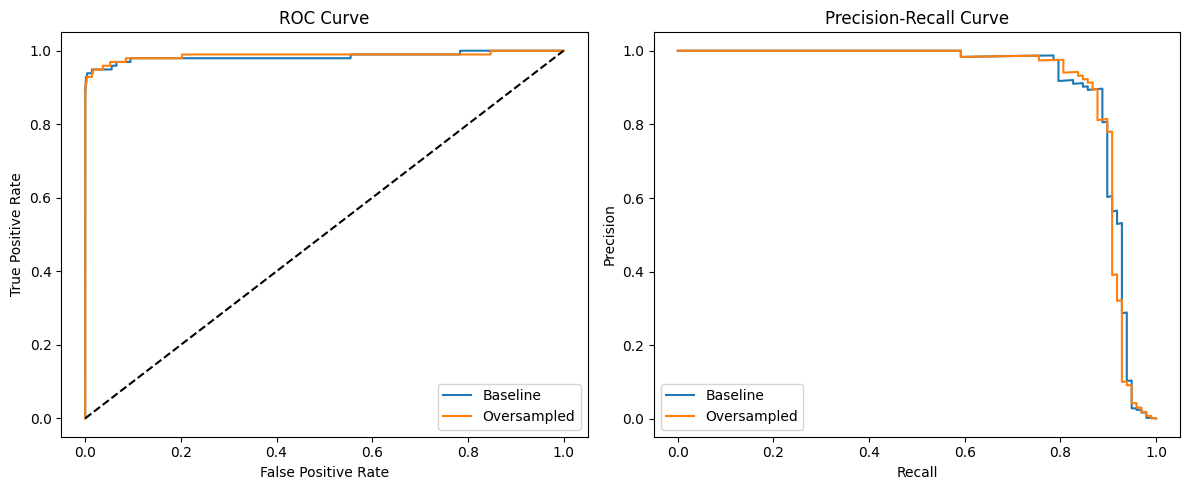

In [ ]:
#precision-recall and ROC curve side by side
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr1, tpr1, _ = roc_curve(y_test, model1.predict_proba(X_test)[:, 1])
fpr2, tpr2, _ = roc_curve(y_test, model2.predict_proba(X_test)[:, 1])
plt.plot(fpr1, tpr1, label='Baseline')
plt.plot(fpr2, tpr2, label='Oversampled')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
prec1, rec1, _ = precision_recall_curve(y_test, model1.predict_proba(X_test)[:, 1])
prec2, rec2, _ = precision_recall_curve(y_test, model2.predict_proba(X_test)[:, 1])
plt.plot(rec1, prec1, label='Baseline')
plt.plot(rec2, prec2, label='Oversampled')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# For Model 2 (Oversampled) no signs of overfitting
train_preds2 = model2.predict(X_train_model2)
train_probs2 = model2.predict_proba(X_train_model2)[:, 1]
train_metrics2 = get_metrics(y_train_model2, train_preds2, train_probs2)
print("Oversampled Model - Train vs. Test Metrics:")
print(pd.DataFrame([train_metrics2, metrics2], index=['Train', 'Test']).T)


Oversampled Model - Train vs. Test Metrics:
                      Train      Test
Accuracy                1.0  0.999614
Balanced Accuracy       1.0  0.903035
Precision               1.0  0.963415
Recall (Sensitivity)    1.0  0.806122
Specificity             1.0  0.999947
F1-Score                1.0  0.877778
G-Mean                  1.0  0.897820
MCC                     1.0  0.881085
ROC-AUC                 1.0  0.938679
PR-AUC                  1.0  0.778246


In [ ]:
#data leakage test
from sklearn.utils import shuffle
shuffled_auc = roc_auc_score(shuffle(y_test, random_state=42), prob_preds2)
print("AUC with shuffled test labels (should be ~0.5):", shuffled_auc)
print("Test shows no dataleakage occurs")


NameError: name 'prob_preds2' is not defined

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, scoring, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Usage (for Model 2, oversampled):
plot_learning_curve(model2, X_train_model2, y_train_model2, scoring='f1', title="Learning Curve (Oversampled)")


KeyboardInterrupt: 

In [ ]:
# Usage (for Model 2, oversampled):
plot_learning_curve(model1, X_train_model1, y_train_model1, scoring='f1', title="Learning Curve (Oversampled)")

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def get_learning_curve(estimator, X, y, scoring='f1', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    return train_sizes, train_mean, test_mean

# Get learning curve data for both models
train_sizes1, train_mean1, test_mean1 = get_learning_curve(model1, X_train_model1, y_train_model1)
train_sizes2, train_mean2, test_mean2 = get_learning_curve(model2, X_train_model2, y_train_model2)

# Plot both curves on the same plot
plt.figure(figsize=(10, 6))

# Baseline model
plt.plot(train_sizes1, train_mean1, 'o-', color="red", label="Train (Baseline)")
plt.plot(train_sizes1, test_mean1, 'o--', color="red", label="CV (Baseline)")

# Oversampled model
plt.plot(train_sizes2, train_mean2, 'o-', color="blue", label="Train (Oversampled)")
plt.plot(train_sizes2, test_mean2, 'o--', color="blue", label="CV (Oversampled)")

plt.title("Learning Curves: Baseline vs. Oversampled")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, prob_preds2, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='Oversampled')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, prob_preds1, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', label='Withou Oversampled')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.utils import shuffle
shuffled_auc = roc_auc_score(shuffle(y_test, random_state=42), prob_preds2)
print("AUC with shuffled test labels (should be ~0.5):", shuffled_auc)


In [ ]:
#2. Bias, Variance, and Model Complexity Goal:Understand and visualize the bias-variance tradeoff as model complexity changes.How to implement:
#Train models of increasing complexity (e.g., varying tree depth in XGBoost).
#Plot training error and test/validation error vs. model complexity.

import matplotlib.pyplot as plt
train_errors = []
val_errors = []
complexities = [2, 4, 6, 8, 10]  # Example: tree depths

for depth in complexities:
    model = xgb.XGBClassifier(max_depth=depth, tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
    model.fit(X_train_model2, y_train_model2)
    train_pred = model.predict(X_train_model2)
    val_pred = model.predict(X_test)
    train_errors.append(1 - accuracy_score(y_train_model2, train_pred))
    val_errors.append(1 - accuracy_score(y_test, val_pred))

plt.plot(complexities, train_errors, label='Train Error')
plt.plot(complexities, val_errors, label='Test Error')
plt.xlabel('Model Complexity (Tree Depth)')
plt.ylabel('Error Rate')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()


In [ ]:
#3. Loss Functions for Classification Goal: Use appropriate loss functions for model assessment.
#How to implement:
#0–1 loss (misclassification rate): 1 - accuracy_score(y_true, y_pred)
#Log-loss (deviance): log_loss(y_true, y_prob) from sklearn.metrics

from sklearn.metrics import log_loss

zero_one_loss = 1 - accuracy_score(y_test, class_preds2)
logloss = log_loss(y_test, prob_preds2)
print(f"0–1 Loss: {zero_one_loss:.4f}, Log-loss: {logloss:.4f}")


In [ ]:
#Training Error vs. Test Error
#Goal:Compare training error to test error to detect overfitting/underfitting.
#How to implement:Print or plot both errors for your final model.

train_pred2 = model2.predict(X_train_model2)
train_prob2 = model2.predict_proba(X_train_model2)[:, 1]
train_error = 1 - accuracy_score(y_train_model2, train_pred2)
test_error = 1 - accuracy_score(y_test, class_preds2)
print(f"Train Error: {train_error:.4f}, Test Error: {test_error:.4f}")


In [ ]:
#5. Model Selection vs. Model Assessment
#Goal:Use validation (not test) data for model selection; use test data only for final assessment.
#How to implement:Use cross-validation or a validation set for hyperparameter tuning.
#Only use the test set once, at the end.



from sklearn.model_selection import cross_val_score

scores = cross_val_score(model2, X_train_model2, y_train_model2, cv=5, scoring='f1')
print(f"Cross-validated F1 scores: {scores}")
print(f"Mean CV F1: {np.mean(scores):.4f}")
# Test set is used only after model selection is complete.


In [ ]:
#7. Practical Recommendations (Cross-Validation, Bootstrap, Avoid Test Set Leakage)
#Goal:Use cross-validation or bootstrap for model selection and error estimation when data is limited.
#Never use the test set for model selection.
#How to implement:#You’re already using cross-validation and a hold-out test set.
#Optionally, use bootstrapping for further error estimation.

from sklearn.utils import resample

bootstrapped_scores = []
for i in range(100):
    X_res, y_res = resample(X_train_model2, y_train_model2, random_state=i)
    model2.fit(X_res, y_res)
    bootstrapped_scores.append(roc_auc_score(y_test, model2.predict_proba(X_test)[:, 1]))
print(f"Bootstrap ROC-AUC mean: {np.mean(bootstrapped_scores):.4f}, std: {np.std(bootstrapped_scores):.4f}")


In [ ]:
#smote for comparison
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score
)
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data



train = pd.concat([train], ignore_index=True)
X_train_smote = train.drop('Class', axis=1)
y_train_smote = train['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']


# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_smote, y_train_smote)


# Show class distribution before and after SMOTE
from collections import Counter

print("Before SMOTE:", Counter(y_train_smote))
print("After SMOTE:", Counter(y_train_res))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res) - len(y_train_smote)
print(f"\nSMOTE added {added_samples} synthetic samples.")




# Train XGBoost classifier with GPU
model_smote = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model_smote.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_smote = model_smote.predict(X_test)
y_pred_prob_smote = model_smote.predict_proba(X_test)[:, 1]  # Needed for curves
y_pred_prob_smote = (y_pred_prob_smote > threshold).astype(int)





# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_prob_smote))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob_smote)
pr_auc = auc(recall, precision)
auc = roc_auc_score(y_test, y_pred_prob_smote) # Use X_meta_test here
print(f"AUC:{auc:.4f}")

#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='darkorange')
#plt.xlabel("Recall")
#plt.ylabel("Precision")
#plt.title("Precision-Recall Curve")
#plt.legend(loc="lower left")
#plt.grid(True)
#plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob_smote)
roc_auc = roc_auc_score(y_test, y_pred_prob_smote)

#plt.figure(figsize=(8, 6))
#plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
#plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
#plt.legend(loc="lower right")
#plt.grid(True)
#plt.show()


Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})

SMOTE added 227057 synthetic samples.
Accuracy: 0.9989817773252344

Confusion Matrix:
 [[56846    18]
 [   12    86]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.88      0.85        98

    accuracy                           1.00     56962
   macro avg       0.91      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC:0.9435


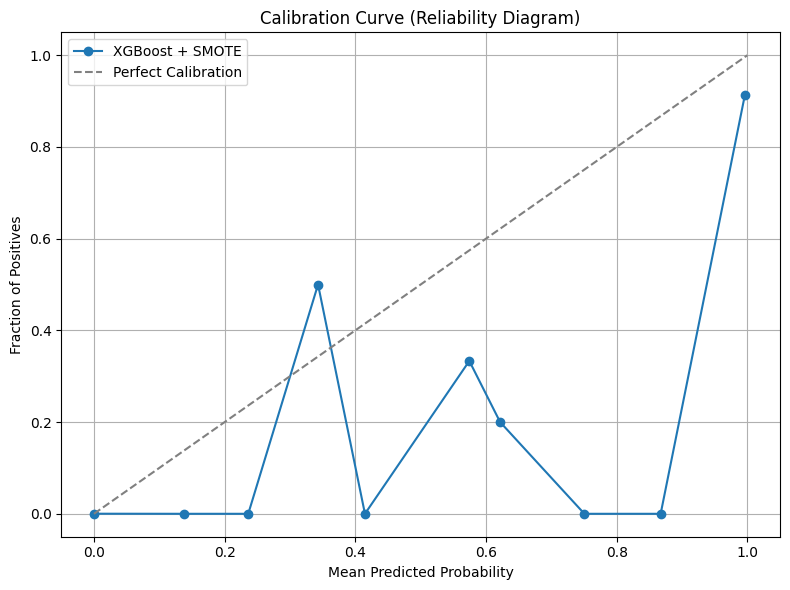

In [ ]:
from sklearn.calibration import calibration_curve

# Get predicted probabilities on the test set (after training your SMOTE model)
y_test_pred_proba = model_smote.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost + SMOTE')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#ADASYN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc, roc_auc_score
)
from imblearn.over_sampling import ADASYN  # Use ADASYN instead of SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt






train = pd.concat([train], ignore_index=True)
X_train_ada = train.drop('Class', axis=1)
y_train_ada = train['Class']

X_test = test.drop('Class', axis=1)
y_test = test['Class']


# Apply ADASYN to training data only
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_ada, y_train_ada)

# Show class distribution before and after ADASYN
from collections import Counter

print("Before ADASYN:", Counter(y_train_ada))
print("After ADASYN:", Counter(y_train_res))

# Calculate how many synthetic samples were added
added_samples = len(y_train_res) - len(y_train_ada)
print(f"\nADASYN added {added_samples} synthetic samples.")

# Train XGBoost classifier with GPU
model_ada = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
model_ada.fit(X_train_res, y_train_res)


# Predict on test set
y_pred_ada = model_ada.predict(X_test)
y_pred_prob_ada = model_ada.predict_proba(X_test)[:, 1]  # Needed for curves
y_pred_prob_ada = (y_pred_prob_ada > threshold).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))
auc = roc_auc_score(y_test, y_pred_prob_ada) # Use X_meta_test here
print(f"AUC:{auc:.4f}")


# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob_ada)
#pr_auc = auc(recall, precision)

#plt.figure(figsize=(8, 6))
#plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='darkorange')
#plt.xlabel("Recall")
#plt.ylabel("Precision")
#plt.title("Precision-Recall Curve")
#plt.legend(loc="lower left")
#plt.grid(True)
#plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob_ada)
roc_auc = roc_auc_score(y_test, y_pred_prob_ada)

#plt.figure(figsize=(8, 6))
#plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
#plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
#plt.legend(loc="lower right")
#plt.grid(True)
#plt.show()


Before ADASYN: Counter({0: 227451, 1: 394})
After ADASYN: Counter({0: 227451, 1: 227394})

ADASYN added 227000 synthetic samples.
Accuracy: 0.9995084442259752

Confusion Matrix:
 [[56848    16]
 [   12    86]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.88      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.94      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC:0.9435


In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, average_precision_score,
    matthews_corrcoef, log_loss
)
import numpy as np

def get_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    gmean = np.sqrt(recall * specificity)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    zero_one_loss = 1 - accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_prob)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_acc,
        "Precision": precision,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-Score": f1,
        "G-Mean": gmean,
        "MCC": mcc,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "0-1 Loss": zero_one_loss,
        "Log-loss": logloss
    }


In [ ]:
#working now
# For baseline
metrics_baseline = get_metrics(y_test, y_score1, y_prob_preds1)

# For oversampled
metrics_custom = get_metrics(y_test, y_score2, y_prob_preds2)

# For SMOTE
metrics_smote = get_metrics(y_test, y_pred_smote, y_pred_prob_smote)


# For ADASYN
metrics_ada = get_metrics(y_test, y_pred_ada, y_pred_prob_ada)


In [ ]:
import pandas as pd

metrics_df = pd.DataFrame([
    metrics_baseline,  # from your baseline model
    metrics_custom,    # from your custom oversampling model
    metrics_smote,     # from SMOTE
    metrics_ada        # from ADASYN
], index=["Baseline", "O-sampling", "SMOTE", "ADASYN"]).T



# Create DataFrame
metrics_df = metrics_df
# Round and highlight best values
styled_metrics = (
    metrics_df.round(4)
    .style.highlight_max(axis=1, color='lightgreen', props='font-weight:bold;')  # Highlight best in row
    .format("{:.4f}")
)

styled_metrics


,Baseline,O-sampling,SMOTE,ADASYN
Accuracy,0.9996,0.9996,0.9995,0.9995
Balanced Accuracy,0.9234,0.9387,0.9386,0.9386
Precision,0.9022,0.8866,0.8269,0.8431
Recall (Sensitivity),0.8469,0.8776,0.8776,0.8776
Specificity,0.9998,0.9998,0.9997,0.9997
F1-Score,0.8737,0.8821,0.8515,0.8600
G-Mean,0.9202,0.9367,0.9366,0.9366
MCC,0.8739,0.8819,0.8516,0.8599
ROC-AUC,0.9839,0.9871,0.9435,0.9435
PR-AUC,0.9066,0.9036,0.5766,0.5766


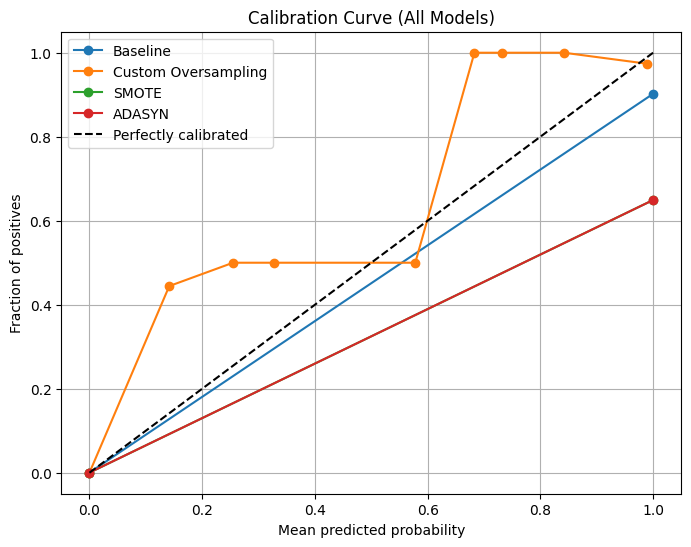

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for label, y_prob in [
    ("Baseline", y_pred_prob1),
    ("Custom Oversampling", y_prob_preds2),
    ("SMOTE", y_pred_prob_smote),
    ("ADASYN", y_pred_prob_ada)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (All Models)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#all learning curves
from sklearn.model_selection import learning_curve
import numpy as np

def get_learning_curve(estimator, X, y, scoring='f1', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    return train_sizes, train_mean, test_mean

# Collect learning curves (use the respective train sets for each model)
curves = []
curves.append(('Baseline', *get_learning_curve(model1, X_train_model1, y_train_model1)))
curves.append(('Custom Oversampling', *get_learning_curve(model2, X_train_model2, y_train_model2)))
curves.append(('SMOTE', *get_learning_curve(model_smote, X_train_smote, y_train_smote)))
curves.append(('ADASYN', *get_learning_curve(model_ada, X_train_ada, y_train_ada)))

# Plot all on one figure
plt.figure(figsize=(10,7))
for label, train_sizes, train_mean, test_mean in curves:
    plt.plot(train_sizes, test_mean, marker='o', label=f'CV (Test) {label}')
    plt.plot(train_sizes, train_mean, marker='.', linestyle='--', label=f'Train {label}')

plt.title("Learning Curves (F1 Score) - All Models")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
#--------------till here-----------

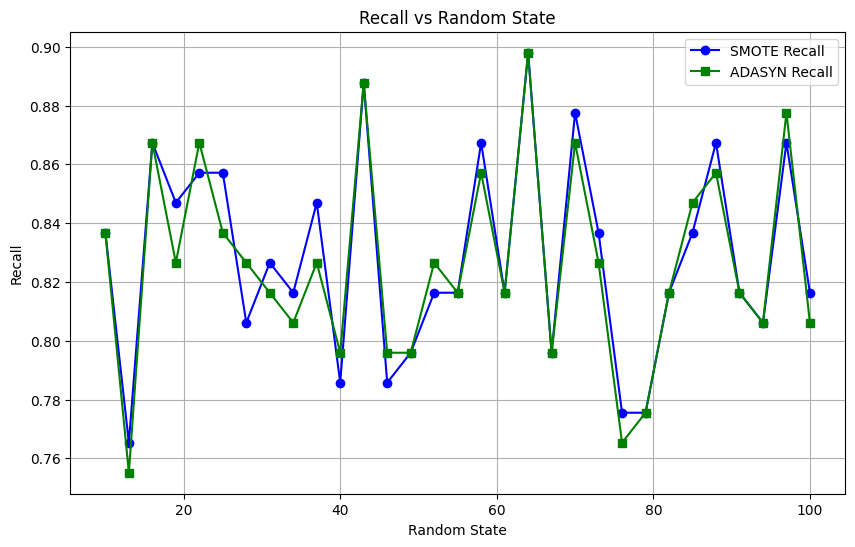

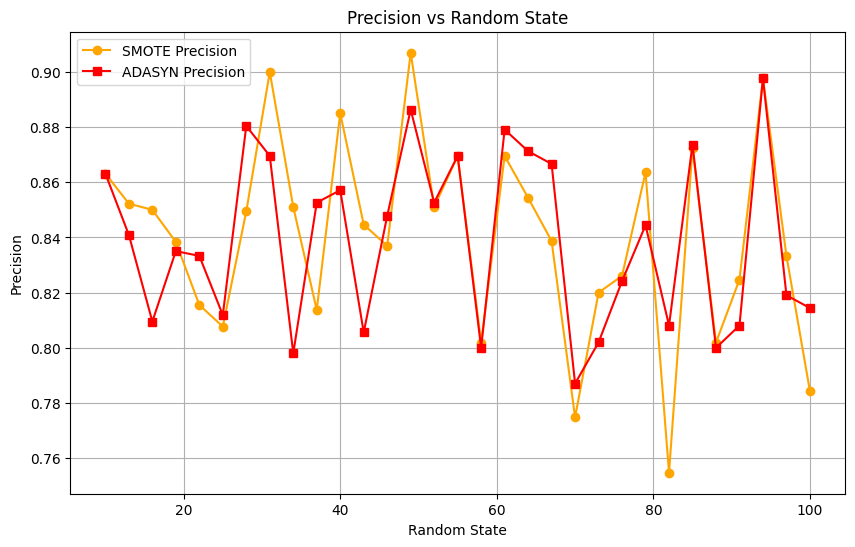

In [ ]:
#ADASYN and SMOTE comaprision in
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from collections import Counter

# Load data
data1 = pd.read_csv('data1.csv')

# Prepare features and target
X = data1.drop('Class', axis=1)
y = data1['Class']

# Ranges of random states
random_states = range(10, 101, 3)

# Store results
recalls_smote, recalls_adasyn = [], []
precisions_smote, precisions_adasyn = [], []

for rs in random_states:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rs, stratify=y)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # Apply ADASYN
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

    # XGBoost classifier
    clf_smote = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)
    clf_adasyn = xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42)

    # Fit models
    clf_smote.fit(X_smote, y_smote)
    clf_adasyn.fit(X_adasyn, y_adasyn)

    # Predict
    y_pred_smote = clf_smote.predict(X_test)
    y_pred_adasyn = clf_adasyn.predict(X_test)

    # Evaluate
    recall_sm = recall_score(y_test, y_pred_smote)
    precision_sm = precision_score(y_test, y_pred_smote)

    recall_ad = recall_score(y_test, y_pred_adasyn)
    precision_ad = precision_score(y_test, y_pred_adasyn)

    recalls_smote.append(recall_sm)
    recalls_adasyn.append(recall_ad)
    precisions_smote.append(precision_sm)
    precisions_adasyn.append(precision_ad)

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(random_states, recalls_smote, label='SMOTE Recall', marker='o', color='blue')
plt.plot(random_states, recalls_adasyn, label='ADASYN Recall', marker='s', color='green')
plt.xlabel("Random State")
plt.ylabel("Recall")
plt.title("Recall vs Random State")
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(random_states, precisions_smote, label='SMOTE Precision', marker='o', color='orange')
plt.plot(random_states, precisions_adasyn, label='ADASYN Precision', marker='s', color='red')
plt.xlabel("Random State")
plt.ylabel("Precision")
plt.title("Precision vs Random State")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#up